In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('MADAR-Corpus-6-train.tsv', sep='\t')
df.columns = ['text', 'dialect']

label2id = {l: i for i, l in enumerate(df['dialect'].unique())}
id2label = {i: l for l, i in label2id.items()}
df['label'] = df['dialect'].map(label2id)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

def tokenize_texts(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize_texts(train_texts)
test_encodings = tokenize_texts(test_texts)

In [5]:
import torch

class MADARDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MADARDataset(train_encodings, train_labels.reset_index(drop=True))
test_dataset = MADARDataset(test_encodings, test_labels.reset_index(drop=True))

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(
    "aubmindlab/bert-base-arabertv2", num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=32,
    save_strategy="no",
    logging_dir='./logs',
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\USER\AppData\Local\Temp\ipykernel_24352\4049695376.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,1.092200
1000,0.882000
1500,0.815900
2000,0.768800
2500,0.721300
3000,0.712900
3500,0.659500
4000,0.591800
4500,0.591900
5000,0.551600


TrainOutput(global_step=21600, training_loss=0.49663789484235976, metrics={'train_runtime': 1035.9702, 'train_samples_per_second': 83.398, 'train_steps_per_second': 20.85, 'total_flos': 2841635672059392.0, 'train_loss': 0.49663789484235976, 'epoch': 2.0})

In [19]:
trainer.save_model('results/arabert-dialect-checkpoint')
tokenizer.save_pretrained('results/arabert-dialect-checkpoint')

('results/arabert-dialect-checkpoint\\tokenizer_config.json',
 'results/arabert-dialect-checkpoint\\special_tokens_map.json',
 'results/arabert-dialect-checkpoint\\vocab.txt',
 'results/arabert-dialect-checkpoint\\added_tokens.json',
 'results/arabert-dialect-checkpoint\\tokenizer.json')

Accuracy: 0.8932407407407408
              precision    recall  f1-score   support

         MSA       0.92      0.96      0.94      1800
         BEI       0.91      0.86      0.88      1800
         RAB       0.93      0.91      0.92      1800
         DOH       0.83      0.89      0.86      1800
         CAI       0.86      0.86      0.86      1800
         TUN       0.92      0.88      0.90      1800

    accuracy                           0.89     10800
   macro avg       0.89      0.89      0.89     10800
weighted avg       0.89      0.89      0.89     10800



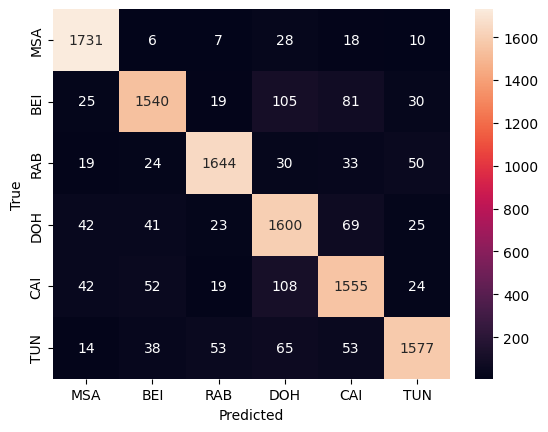

In [7]:
preds = trainer.predict(test_dataset)
y_pred = preds.predictions.argmax(-1)
y_true = test_labels.values

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_labels)]))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[id2label[i] for i in range(num_labels)], yticklabels=[id2label[i] for i in range(num_labels)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def predict_dialect_arabert(text):
    encoding = tokenizer([text], padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        output = model(**{k: v for k, v in encoding.items()})
        pred_id = output.logits.argmax(-1).item()
        return id2label[pred_id]

samples = ["عاوز واحد كشري بعد ازنك",
           "كيفاش نقلك يا رويح كبيدي",
           "واحد شاهي لاهنت", "كم ثمن هذه الجارية"]

encoding = tokenizer(
    samples,
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoding = {k: v.to(device) for k, v in encoding.items()}
model = model.to(device)
model.eval()

with torch.no_grad():
    output = model(**encoding)
    pred_ids = output.logits.argmax(-1).tolist()
    predicted_labels = [id2label[pred_id] for pred_id in pred_ids]

for text, label in zip(samples, predicted_labels):
    print(f"{text} --> Predicted Dialect: {label}")


عاوز واحد كشري بعد ازنك --> Predicted Dialect: CAI
كيفاش نقلك يا رويح كبيدي --> Predicted Dialect: TUN
واحد شاهي لاهنت --> Predicted Dialect: DOH
كم ثمن هذه الجارية --> Predicted Dialect: MSA
